# Classification of Stellar Objects

**Authors:** Margarita Kapustina, Linda Chu, Muhammad Shahbaz Murtaza, Brendan Yuen

### Introduction

In astronomy, the classification of stars, galaxies, and quasars is fundamental towards the understanding of our own galaxy. Galaxies are large systems of stars (Greshko, 2021), whereas quasars are active galactic nuclei powered by supermassive black holes found at the center of massive galaxies (Bañados et al. 2016). The three can be hard to differentiate solely through observation as they all radiate different wavelengths, hence, astronomers use other spectral characteristics for object identification.

This project aims to answer the following predictive question: Is it possible to use Sloan Digital Sky Survey (SDSS) measurements to predict whether a future stellar body of an unknown type is a star, quasar or galaxy?

The dataset used in our project contains 100,000 observations of space, each of which are classified as a star, galaxy, or quasar, based on their spectral characteristics. Every observation was taken by the SDSS and was given a unique object identifier.

Dataset of interest: 2017 Stellar Classification (SDSS17) https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17

The original dataset contained 17 variables, of which 7 we are interested in. The variables of interest we will use in our dataset include:

- **u**: the ultraviolet filter in the photometric system
- **g**: the green filter in the photometric system
- **r**: the red filter in the photometric system
- **i**: the near Infrared filter in the photometric system
- **z**: the infrared filter in the photometric system
- **class**: the object class (galaxy, star, or quasar object)
- **redshift**: the redshift value based on the increase in wavelength

The class variable is the categorical variable to be predicted. Photometrics measure intensities of different wavelengths and are used by astronomers to study the structure and composition of celestial objects (Grier & Rivkin, 2019), whereas redshift is used in distance, velocity, and other calculations. Hence, we chose these variables as potential predictors.


### Methods

The variables we will use to classify the type of a new SDSS observation include all the photometric measurements (originally labeled u, g, r, i, and z) and the redshift. Previous literature and classification models have demonstrated that many of these factors correlate with stellar body types and may contribute to classifying an astronomical event of type galaxy, quasar or star (Finlay-Freundlich, 1954; Wierzbiński et al. 2021; Simet et al. 2021). 

In our analysis, we will use K-nearest neighbors. Prior to the preprocessing of our training data, we will standardize (i.e. scale and center) our training data to prevent the scales of predictors from unevenly impacting our model. We will also visualize our data to see how the new observation fits with the current dataset and to gauge the accuracy of our prediction.

We start by loading the packages necessary for our analysis.

In [21]:
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)
options(repr.matrix.max.rows = 6)

We will use the read_csv function to read our dataset of interest and assign it to an object called 'star_data'. Then we will verify whether any columns are missing information by counting how many cells have 'NA' in each column.

In [6]:
star_data <- read_csv("https://raw.githubusercontent.com/Margokap/DSCI100-group-03/main/star_classification.csv")

map_df(star_data, ~sum(is.na(.)))

Rows: 100000 Columns: 18
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): class
dbl (17): obj_ID, alpha, delta, u, g, r, i, z, run_ID, rerun_ID, cam_col, fi...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


No cells were missing information. Since we are only interested in the photometric variables, the redshift, and the class, we kept only these columns and assigned it to an object called 'star_data_tidy'.

In [7]:
star_data_tidy <- select(star_data, u, g, r, i, z, redshift, class)

star_data_tidy

u,g,r,i,z,redshift,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
23.87882,22.27530,20.39501,19.16573,18.79371,0.6347936,GALAXY
24.77759,22.83188,22.58444,21.16812,21.61427,0.7791360,GALAXY
25.26307,22.66389,20.60976,19.34857,18.94827,0.6441945,GALAXY
⋮,⋮,⋮,⋮,⋮,⋮,⋮
21.16916,19.26997,18.20428,17.69034,17.35221,0.1433656,GALAXY
25.35039,21.63757,19.91386,19.07254,18.62482,0.4550396,GALAXY
22.62171,21.79745,20.60115,20.00959,19.28075,0.5429442,GALAXY


We then changed the column titles to be more comprehensive, which concluded the tidying of the data set.

In [8]:
names(star_data_tidy) <- c("UV_filter",
                            "Green_filter",
                            "Red_filter",
                            "Near_Infrared_filter",
                            "Infrared_filter",
                            "Redshift",
                            "Stellar_object")
star_data_tidy

UV_filter,Green_filter,Red_filter,Near_Infrared_filter,Infrared_filter,Redshift,Stellar_object
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
23.87882,22.27530,20.39501,19.16573,18.79371,0.6347936,GALAXY
24.77759,22.83188,22.58444,21.16812,21.61427,0.7791360,GALAXY
25.26307,22.66389,20.60976,19.34857,18.94827,0.6441945,GALAXY
⋮,⋮,⋮,⋮,⋮,⋮,⋮
21.16916,19.26997,18.20428,17.69034,17.35221,0.1433656,GALAXY
25.35039,21.63757,19.91386,19.07254,18.62482,0.4550396,GALAXY
22.62171,21.79745,20.60115,20.00959,19.28075,0.5429442,GALAXY


To understand how our data was distributed across each stellar object, in other words to compare the proportions of objects belonging to each stellar class, we created a bar graph visualization (see Figure 1.0).

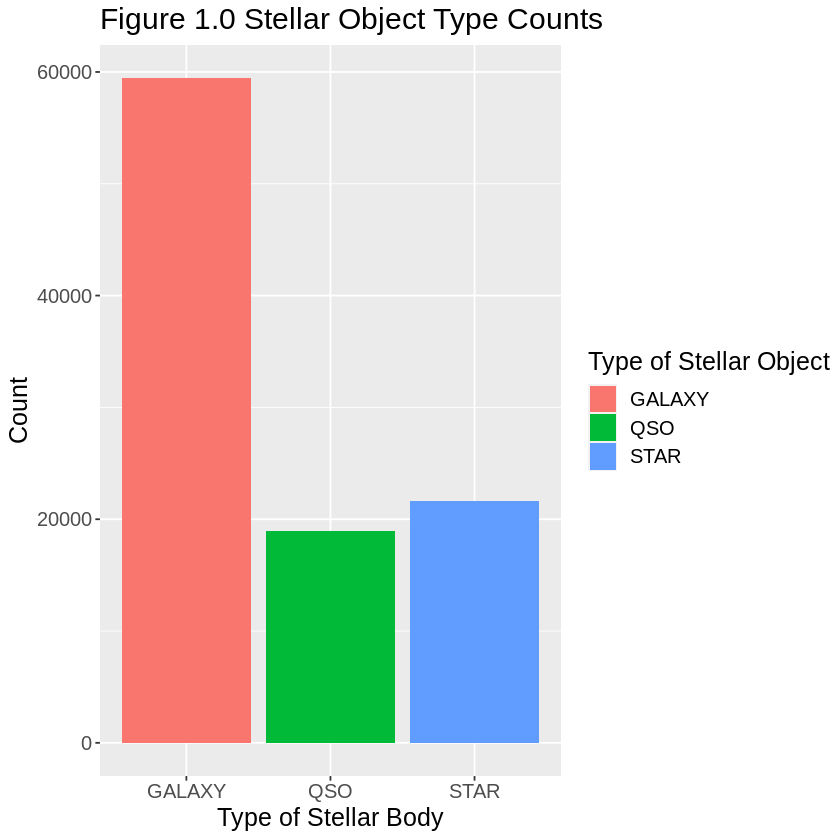

In [13]:
count <- star_data_tidy |> 
         group_by(Stellar_object) |>
         summarize(count = n())

star_counts_plot <- ggplot(count, aes(x = Stellar_object, y = count, fill = Stellar_object)) + 
    geom_bar(stat = "identity") +
    labs(x = "Type of Stellar Body", fill = "Type of Stellar Object", y = "Count") + 
    theme(text = element_text(size = 15)) +
    ggtitle("Figure 1.0 Stellar Object Type Counts") +
    scale_color_brewer(palette = "Set2")

star_counts_plot

It is clear that the majority class is galaxy as there are much more galaxy objects than quasar or star objects. To counter this imbalance, we sampled 1000 observations of each type of Stellar Object, bound the samples, and sampled 1000 observations of the bound samples.

In [14]:
#sampling from data to make data balanced
star_data_star <- star_data_tidy |>
                  filter(Stellar_object == "STAR") |>
                  sample_n(1000)

star_data_galaxy <- star_data_tidy |>
                  filter(Stellar_object == "GALAXY") |>
                  sample_n(1000)

star_data_qso <- star_data_tidy |>
                  filter(Stellar_object == "QSO") |>
                  sample_n(1000)

star_data_balanced <- rbind(star_data_qso, star_data_galaxy, star_data_star) |>
                  sample_n(1000)

star_table <- star_data_balanced |>
              group_by(Stellar_object) |>
              summarize(Counts = n())
star_table

Stellar_object,Counts
<chr>,<int>
GALAXY,327
QSO,329
STAR,344


The resulting data set is much more balanced. To start our classification analysis, we then split our balanced data into two subsets: the training set and the testing set. To prevent any organizational structure of the data from influencing the model, we set the strata parameter to the stellar object. The training set also contains 75% of the balanced data.

In [15]:
star_split <- initial_split(star_data_balanced, prop = 0.75, strata = Stellar_object)
star_training <- training(star_split)
star_testing <- testing(star_split)

We then visualized each of our photometrics against redshift.

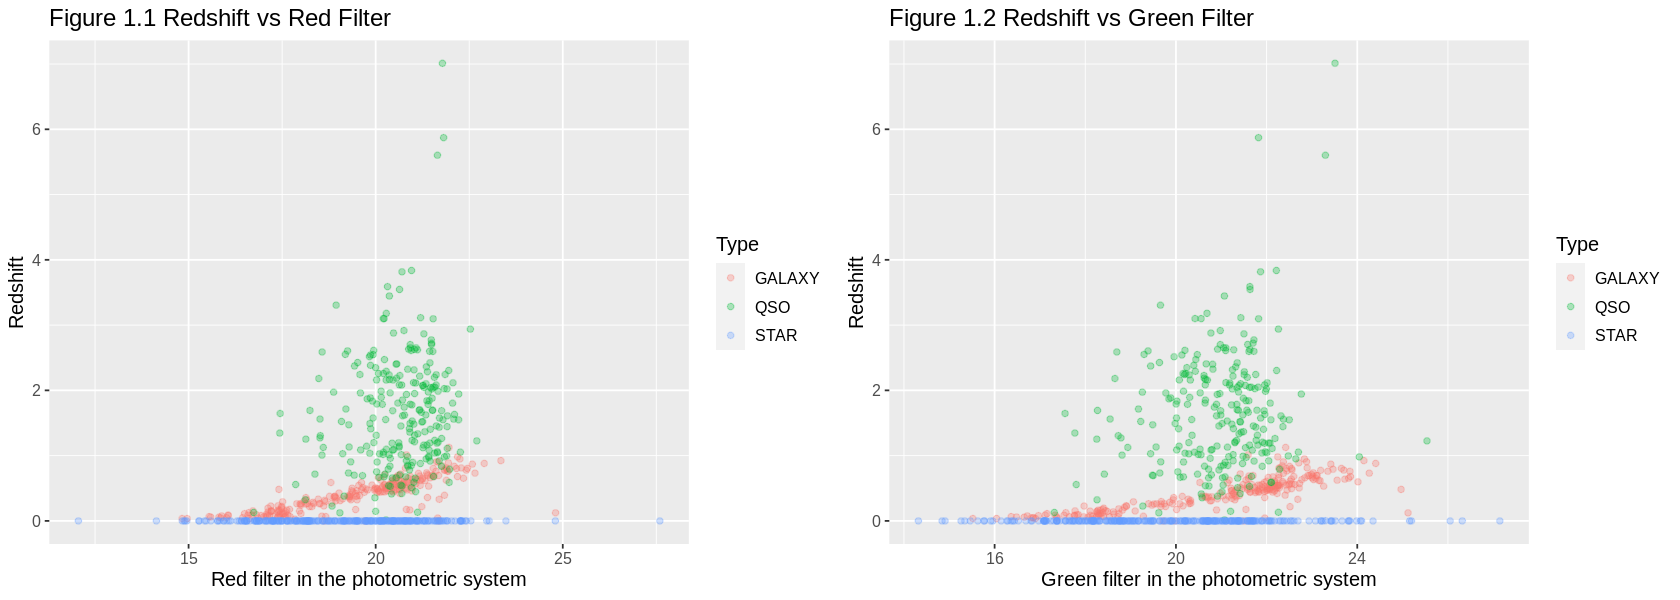

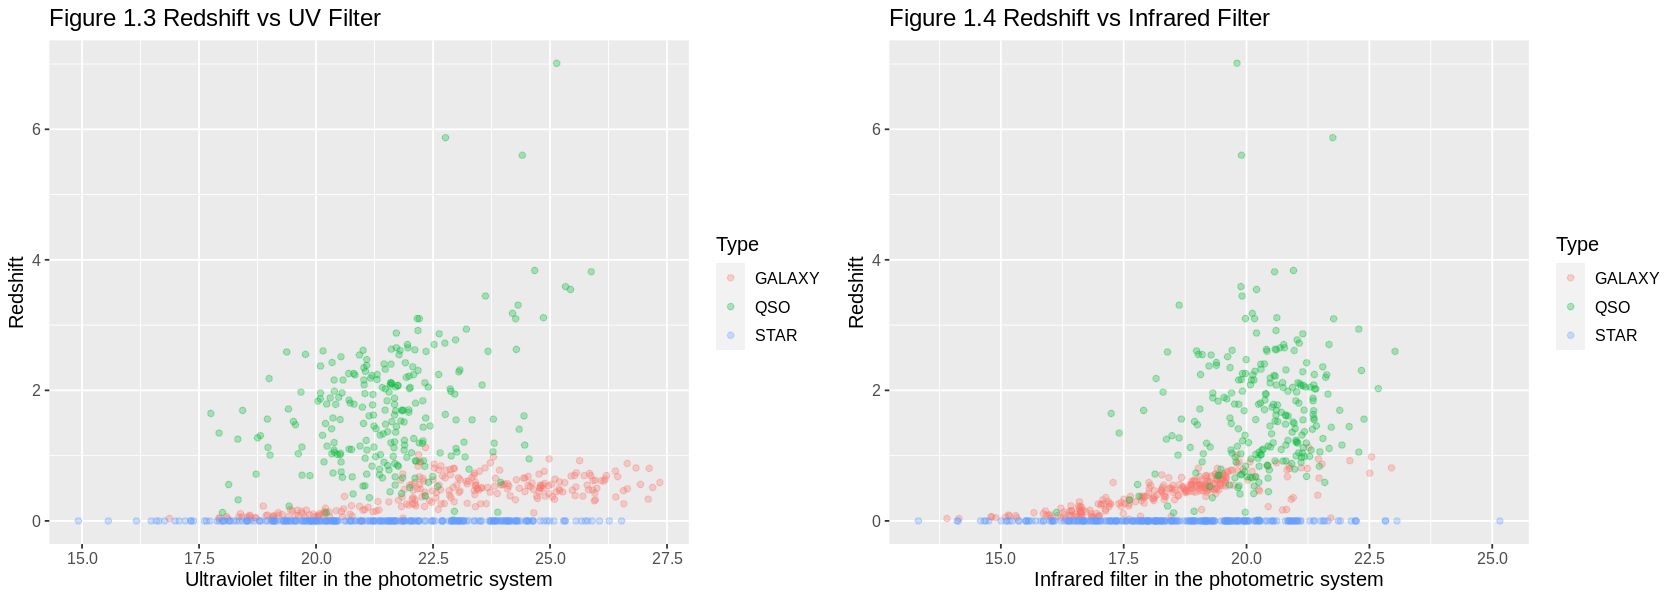

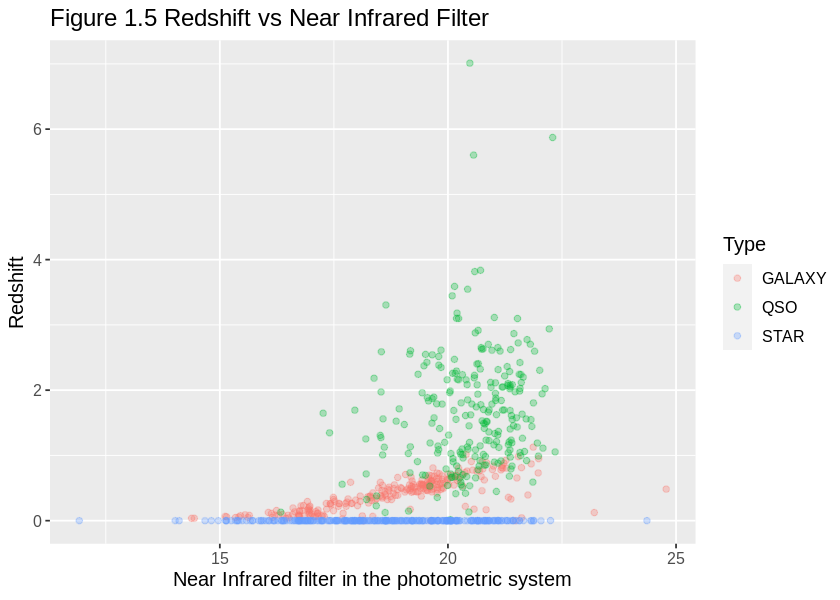

In [60]:
options(repr.plot.height = 5, repr.plot.width = 14)

rs_vs_r <- ggplot(star_training, aes(y = Redshift, x = Red_filter, color = Stellar_object)) +
                              geom_point(alpha = 0.3) +
                              labs(y = "Redshift", x = "Red filter in the photometric system", color = "Type") +
                              theme(text = element_text(size = 12)) +
                              ggtitle("Figure 1.1 Redshift vs Red Filter")

rs_vs_g <- ggplot(star_training, aes(y = Redshift, x = Green_filter, color = Stellar_object)) +
                              geom_point(alpha = 0.3) +
                              labs(y = "Redshift", x = "Green filter in the photometric system", color = "Type") +
                              theme(text = element_text(size = 12)) +
                              ggtitle("Figure 1.2 Redshift vs Green Filter")

rs_vs_uv <- ggplot(star_training, aes(y = Redshift, x = UV_filter, color = Stellar_object)) +
                              geom_point(alpha = 0.3) +
                              labs(y = "Redshift", x = "Ultraviolet filter in the photometric system", color = "Type") +
                              theme(text = element_text(size = 12)) +
                              ggtitle("Figure 1.3 Redshift vs UV Filter")

rs_vs_ir <- ggplot(star_training, aes(y = Redshift, x = Infrared_filter, color = Stellar_object)) +
                              geom_point(alpha = 0.3) +
                              labs(y = "Redshift", x = "Infrared filter in the photometric system", color = "Type") +
                              theme(text = element_text(size = 12)) +
                              ggtitle("Figure 1.4 Redshift vs Infrared Filter")

rs_vs_nir <- ggplot(star_training, aes(y = Redshift, x = Near_Infrared_filter, color = Stellar_object)) +
                              geom_point(alpha = 0.3) +
                              labs(y = "Redshift", x = "Near Infrared filter in the photometric system", color = "Type") +
                              theme(text = element_text(size = 12)) +
                              ggtitle("Figure 1.5 Redshift vs Near Infrared Filter")

plot_grid(rs_vs_r, rs_vs_g)
plot_grid(rs_vs_uv, rs_vs_ir)

options(repr.plot.height = 5, repr.plot.width = 14/2)
rs_vs_nir


Results:

Discussion:

Impact of our work:



**Literature Cited:**

+ Bañados, E.,  Venemans, B. P., Decarli, R., Farina, E. P., Mazzucchelli, C., Walter, F.,  Fan, X.,  Stern, D., Schlafly, E., Chambers, K. C., Rix, H-W.,  Jiang, L., McGreer, I., Simcoe, R., Wang, F., Yang, J., Morganson, E., De Rosa, G., Greiner, J., …Q. Yang. (2016). THE PAN-STARRS1 DISTANT z > 5.6 QUASAR SURVEY: MORE THAN 100 QUASARS WITHIN THE FIRST GYR OF THE UNIVERSE. The American Astronomical Society. 227(1). doi: 10.3847/0067-0049/227/1/11

+ Becker, I., Pichara, K., Catelan, M., Protopapas, P., Aguirre, C., & Nikzat, F. (2020). Scalable end-to-end recurrent neural network for variable star classification. Monthly Notices of the Royal Astronomical Society, 493(2), 2981-2995.

+ Finlay-Freundlich, E. (1954). Red-shifts in the spectra of celestial bodies. Proceedings of the Physical Society. Section A, 67(2), 192.

+ Greshko, M. (2021, May 4). Galaxy Information and facts. Science. Retrieved March 11, 2023, from https://www.nationalgeographic.com/science/article/galaxies 

+ Simet, M., Chartab, N., Lu, Y., & Mobasher, B. (2021). Comparison of observed galaxy properties with semianalytic model predictions using machine learning. The Astrophysical Journal, 908(1), 47.

+ The European Space Agency. (n.d.). What is 'red shift'? ESA. url: https://www.esa.int/Science_Exploration/Space_Science/What_is_red_shift 

+ Grier, A.J, & Rivkin, A.S. (2019). Airless Bodies of the Inner Solar System. Understanding the Process Affecting Rocky, Airless Surfaces. Chapter 4, 47-94

+ Wierzbiński, M., Pławiak, P., Hammad, M., & Acharya, U. R. (2021). Development of accurate classification of heavenly bodies using novel machine learning techniques. Soft Computing, 25(10), 7213-7228.
